In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import random
from tqdm import tqdm
from time import time

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Lambda, Input, Flatten, Dense, Concatenate
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam 
import tensorflow.keras.backend as K

In [2]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

In [3]:
def load_data():
    mnist_data = tf.keras.datasets.mnist.load_data()
    return mnist_data

In [4]:
def data_preprocessing(mnist_data):
    (X_train, y_train), (X_test, y_test) = mnist_data
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    return (X_train, y_train), (X_test, y_test)

In [5]:
mnist_data = load_data()
(X_train, y_train), (X_test, y_test) = data_preprocessing(mnist_data)

In [6]:
print("X_train Shape: {}".format(X_train.shape))
print("y_train Shape: {}".format(y_train.shape))
print("X_test Shape: {}".format(X_test.shape))
print("y_test Shape: {}".format(y_test.shape))

X_train Shape: (60000, 28, 28)
y_train Shape: (60000,)
X_test Shape: (10000, 28, 28)
y_test Shape: (10000,)


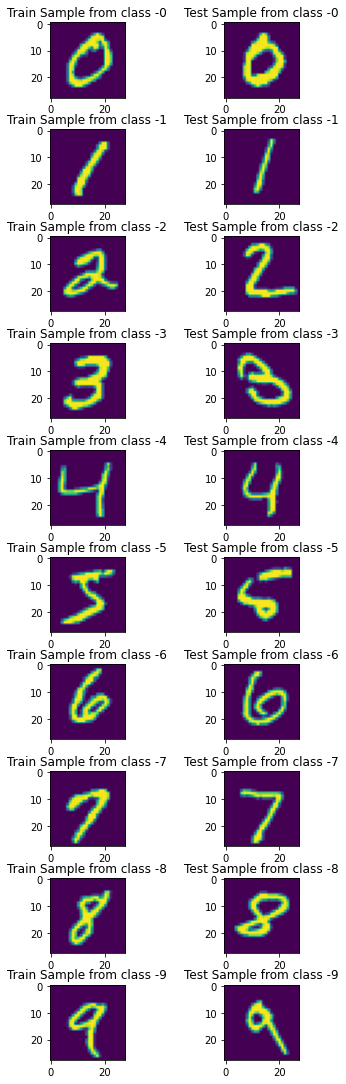

In [7]:
f, ax = plt.subplots(10,2, figsize = (5,15))
f.tight_layout()
for j in range(10):
    k = 0
    while(True):
        if y_train[k] == j:
            ax[j,0].imshow(X_train[k])
            ax[j,0].set_title("Train Sample from class -"+str(j))
            break
        k+=1
    
    k = 0
    while(True):
        if y_test[k] == j:
            ax[j,1].imshow(X_test[k])
            ax[j,1].set_title("Test Sample from class -"+str(j))
            break
        k+=1
        

In [8]:
def make_pairs(images, labels):

    X, y = [],[]
    num_classes = 10
    label_to_idx = [np.where(labels==i)[0] for i in range(num_classes)]

    for i in tqdm(range(len(images))):
        
        #same image type - 0
        lbl1 = labels[i]
        id = random.choice(label_to_idx[lbl1])
        X.append([images[i], images[id]])
        y.append([0])

        #different image type - 1
        lbl2 = random.randint(0, len(label_to_idx)-1)
        while(lbl2 == lbl1):
            lbl2 = random.randint(0, len(label_to_idx)-1)
        #print(lbl2)
        id = random.choice(label_to_idx[lbl2])
        X.append([images[i], images[id]])
        y.append([1])
    
    X, y = np.array(X), np.array(y)
    return X,y


In [9]:
X_train_pair, y_train_pair = make_pairs(X_train, y_train)
X_test_pair, y_test_pair = make_pairs(X_test, y_test)

100%|██████████| 10000/10000 [00:00<00:00, 170036.36it/s]


In [10]:
print("X_train Shape: {}".format(X_train_pair.shape))
print("y_train Shape: {}".format(y_train_pair.shape))
print("X_test Shape: {}".format(X_test_pair.shape))
print("y_test Shape: {}".format(y_test_pair.shape))

X_train Shape: (120000, 2, 28, 28)
y_train Shape: (120000, 1)
X_test Shape: (20000, 2, 28, 28)
y_test Shape: (20000, 1)


In [11]:
def display_data_pairs(X,y):
    f, ax = plt.subplots(10,4, figsize = (8,15))
    f.tight_layout()

    j=0
    while(True):
        if j==10:
            break
        k = random.randint(0,len(X))
        if y[k] == 0:
            ax[j,0].imshow(X[k][0])
            ax[j,0].set_title("Anchor Image - "+str(j))
            ax[j,1].imshow(X[k][1])
            ax[j,1].set_title("Positive Image - "+str(j))
            
            k+=1
            ax[j,2].imshow(X[k][0])
            ax[j,2].set_title("Anchor Image - "+str(j))
            ax[j,3].imshow(X[k][1])
            ax[j,3].set_title("Negative Image - "+str(j))
            j+=1

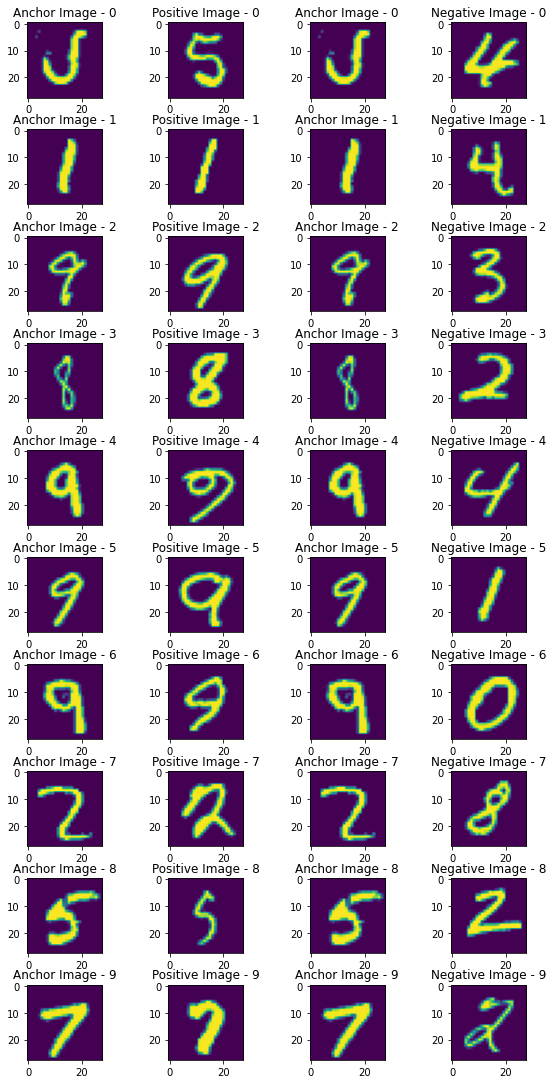

In [12]:
display_data_pairs(X_train_pair, y_train_pair)

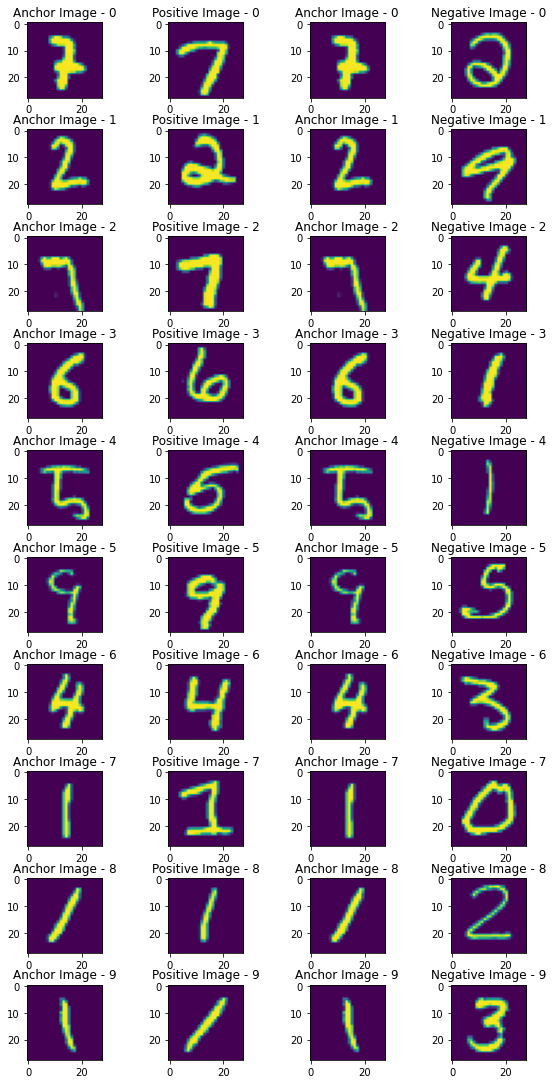

In [13]:
display_data_pairs(X_test_pair, y_test_pair)

"""
logdir = "logs/{}".format(time())
tensorboard_callback = TensorBoard(log_dir=logdir)
"""

In [14]:
def plot_metric(history):
    acc, val_acc, loss, val_loss = history['accuracy'], history['val_accuracy'], history['loss'], history['val_loss']
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(acc, label = 'Training Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc = "upper left")

    plt.subplot(1,2,2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc = "upper left")


In [15]:
def euclidean_dist(vect):
    x, y = vect
    sum_square = K.sum(K.square(x-y), axis = 1, keepdims = True)
    result = K.maximum(sum_square, K.epsilon())
    return result

In [16]:
def get_model():
    input = Input((28,28))
    x = Flatten()(input)
    x = Dense(128, activation ='relu')(x)
    dense = Model(input, x)

    input1 = Input((28,28))
    input2 = Input((28,28))

    dense1 = dense(input1)
    dense2 = dense(input2)

    merge_layer = Lambda(euclidean_dist)([dense1, dense2])
    dense_layer = Dense(1, activation = 'sigmoid')(merge_layer)
    model =  Model(inputs = [input1, input2], outputs = dense_layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [17]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          100480      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [18]:
history = model.fit([X_train_pair[:,0], X_train_pair[:,1]], y_train_pair, batch_size = 16, epochs = 8,verbose=1, shuffle= True, validation_split = 0.2)

Epoch 1/8
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5962/6000 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8579WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001B8F9770048> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

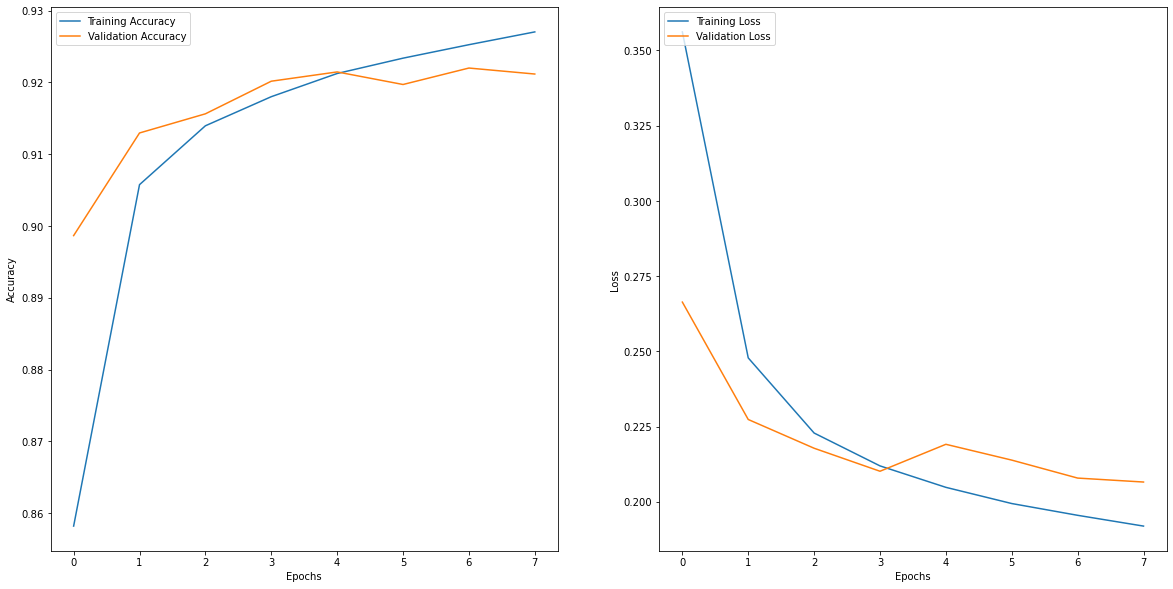

In [19]:
plot_metric(history.history)

In [20]:
results = model.evaluate([X_test_pair[:,0],X_test_pair[:,1]], y_test_pair, batch_size=16)
print("Test Data Accuracy: {:.2f}%".format(results[1]*100))
print("Test Data loss:     {:.2f}".format(results[0]))

1250/1250 [==============================] - 1s 1ms/step - loss: 0.2176 - accuracy: 0.9172
Test Data Accuracy: 91.72%
Test Data loss:     0.22
